#Student Name: Bianjiang Yang
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 21 01:56:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
%tensorflow_version 1.x
!pip install cleverhans==2.1.0

TensorFlow 1.x selected.
     |████████████████████████████████| 74 kB 2.1 MB/s 
     |████████████████████████████████| 154 kB 15.7 MB/s 
     |████████████████████████████████| 42 kB 901 kB/s 


In [3]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

Using TensorFlow backend.


#Part 1: Training a target classifier

In [4]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0

#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(60000,784)
data_test = data_test.reshape(10000,784)

#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

#Create classifier architecture, compile it, and train it
def Classifier():
    model = Sequential()
    model.add(Dense(100, activation="relu", input_dim = 784))
    model.add(BatchNormalization())
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax"))
    return model

Classifier = Classifier()

#Compile model using an appropriate loss and optimizer algorithm
Classifier.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

#Train the model and assign training meta-data to a variable
Classifier_mdata = Classifier.fit(
  data_train, 
  labels_train,
  validation_data=(data_test, labels_test),
  epochs=50,
  batch_size=256,
)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.3217 - accuracy: 0.9062 - val_loss: 0.2191 - val_accuracy: 0.9515
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1175 - accuracy: 0.9654 - val_loss: 0.1107 - val_accuracy: 0.9651
Epoch 3/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0795 - accuracy: 0.9767 - val_loss: 0.0978 - val_accuracy: 0.9706
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0583 - accuracy: 0.9832 - val_loss: 0.0904 - val_accuracy: 0.9719
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.0865 - val_accuracy: 0.9739
Epoch 6/50
60000/60000 [==============================] - 2s 26us/st

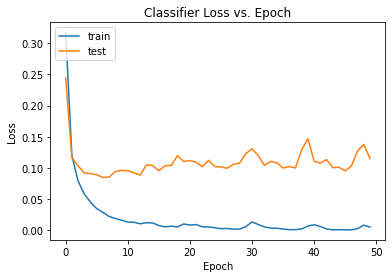

In [ ]:
#Plot loss vs epoch
plt.plot (Classifier_mdata.history [ 'loss' ] )
plt.plot (Classifier_mdata.history [ 'val_loss' ] )
plt.title ('Classifier Loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['train' , 'test'] , loc='upper left')
plt.show()

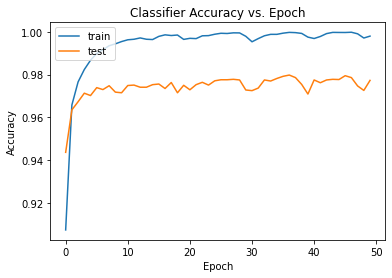

In [ ]:
#Plot accuracy vs epoch
plt.plot(Classifier_mdata.history['accuracy'])
plt.plot(Classifier_mdata.history['val_accuracy'])
plt.title('Classifier Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Print accuracy of classifier on MNIST testing data
Classifier_scores = Classifier.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(Classifier_scores[1]*100))

10000/10000 [==============================] - 1s 58us/step
Accuracy: 97.73%


In [5]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(Classifier)

#Part 2: The Fast Gradient Method (FGM)

In [6]:
#Implementing the FGM attack

#FGM Instance on trained classifier from Part 1
FGM = FastGradientMethod(wrap, sess=sess)

#Attack parameters
FGM_params = {'eps': 0.25,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
FGM_attack_data = FGM.generate_np(data_test, **FGM_params)

#Evaluate accuracy on target classifier 
FGM_adv_scores = Classifier.evaluate(FGM_attack_data, labels_test)
print("FGM Adversarial Attack Accuracy: %.2f%%" %(FGM_adv_scores[1]*100))




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 1s 57us/step
FGM Adversarial Attack Accuracy: 6.05%


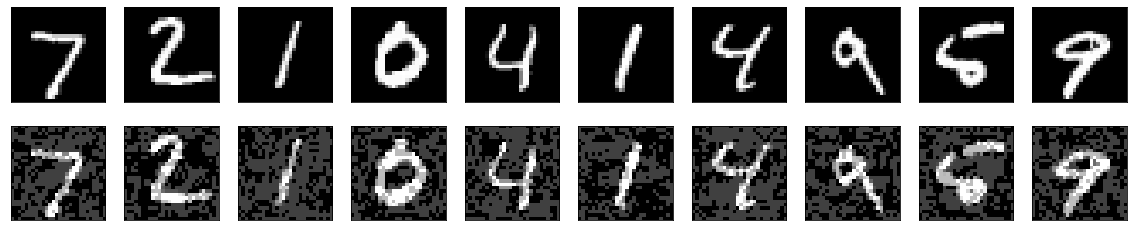

In [ ]:
#Show ten original samples and their corresponding adversarial samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display adversarial
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(FGM_attack_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
#Implementing Detection via Autoencoders
def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
autoencoder = autoencoder()
autoencoder.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['accuracy'],
)
autoencoder_mdata = autoencoder.fit(
  data_train, 
  data_train,
  validation_data=(data_test, data_test),
  epochs=50,
  batch_size=256,
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0372 - accuracy: 0.0100 - val_loss: 0.0152 - val_accuracy: 0.0101
Epoch 2/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0122 - accuracy: 0.0114 - val_loss: 0.0093 - val_accuracy: 0.0123
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084 - accuracy: 0.0135 - val_loss: 0.0070 - val_accuracy: 0.0125
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0066 - accuracy: 0.0126 - val_loss: 0.0058 - val_accuracy: 0.0105
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0057 - accuracy: 0.0124 - val_loss: 0.0052 - val_accuracy: 0.0111
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0051 - accuracy: 0.0133 - val_loss: 0.0046 - val_accuracy: 0.0137
Epoch 7/50
60000/60000 [==============================] - 1s 23us/st

In [9]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
FGM_attack_data_train = FGM.generate_np(data_train, **FGM_params)

# Obtain reconstruction errors on training set and determine a threshold 
reconstruction = autoencoder.predict(FGM_attack_data_train)
error = keras.losses.mean_squared_error(reconstruction, FGM_attack_data_train)
# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)
#print(error.shape)
# Determine threshold (based on min in this case) and print it 
threshold = np.amin(error)
print("Threshold: ", threshold)

# Calculate error of adversarial testing set
FGM_attack_data_test = FGM.generate_np(data_test, **FGM_params)
reconstruction_test = autoencoder.predict(FGM_attack_data_test)
error_test = keras.losses.mean_squared_error(reconstruction_test, FGM_attack_data_test)
error_test = error_test.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
count = 0
for e in error_test:
    if e > threshold:
        count+=1
# Print number of true positive samples
print("Number of true positive adversarial examples: ", count)

# Determine false positives on benign testing set
predictions_true = autoencoder.predict(data_test)
error_true = keras.losses.mean_squared_error(data_test, predictions_true)
error_true = error_true.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
false_pos_count = 0
for i in error_true:
  if i > threshold:
    false_pos_count+=1
    
# Print number of false positive samples
print("Number of false positive adversarial examples: ", false_pos_count) 

Threshold:  0.020726185
Number of true positive adversarial examples:  9999
Number of false positive adversarial examples:  0


#Part 3: Projected Gradient Descent

In [ ]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params = {'eps': 0.25,
              'eps_iter': 0.01,
              'nb_iter': 20,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
pgd_attack_data = pgd.generate_np(data_test, **pgd_params)
pgd_attack_data_train = pgd.generate_np(data_train, **pgd_params)
#Evaluate accuracy on target classifier 
pgd_adv_scores = Classifier.evaluate(pgd_attack_data, labels_test)
print("pgd Adversarial Attack Accuracy: %.2f%%" %(pgd_adv_scores[1]*100))


10000/10000 [==============================] - 1s 58us/step
pgd Adversarial Attack Accuracy: 1.12%


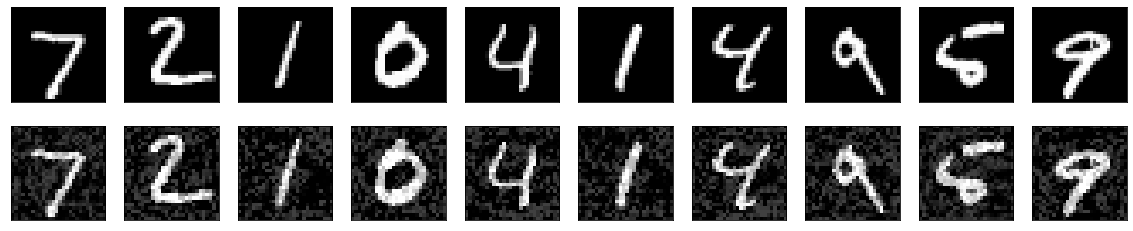

In [ ]:
#Show ten original samples and their corresponding adversarial samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display adversarial
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pgd_attack_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Implementing the adversarial training defense
adv_trained_clf = Classifier
#Compile model using an appropriate loss and optimizer algorithm
adv_trained_clf.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
print(np.concatenate([data_train, pgd_attack_data_train]).shape)
#Train the model and assign training meta-data to a variable
adv_trained_clf_mdata = adv_trained_clf.fit(
  np.concatenate([data_train, pgd_attack_data_train]), 
  np.concatenate([labels_train,labels_train]),
  validation_data=(pgd_attack_data, labels_test),
  epochs=50,
  batch_size=256,
)

(120000, 784)
Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 4s 34us/step - loss: 0.3040 - accuracy: 0.9842 - val_loss: 1.7457 - val_accuracy: 0.9752
Epoch 2/50
120000/120000 [==============================] - 3s 27us/step - loss: 0.1409 - accuracy: 0.9885 - val_loss: 1.5728 - val_accuracy: 0.9749
Epoch 3/50
120000/120000 [==============================] - 3s 27us/step - loss: 0.0895 - accuracy: 0.9908 - val_loss: 1.4291 - val_accuracy: 0.9745
Epoch 4/50
120000/120000 [==============================] - 3s 27us/step - loss: 0.0578 - accuracy: 0.9926 - val_loss: 1.2714 - val_accuracy: 0.9773
Epoch 5/50
120000/120000 [==============================] - 3s 27us/step - loss: 0.0447 - accuracy: 0.9933 - val_loss: 1.2547 - val_accuracy: 0.9764
Epoch 6/50
120000/120000 [==============================] - 3s 27us/step - loss: 0.0341 - accuracy: 0.9943 - val_loss: 1.1238 - val_accuracy: 0.9760
Epoch 7/50
120000/120000 [===============

In [ ]:
#Using the defense to evaluate the accuracy of the perturbed data
adv_trained_clf_scores = adv_trained_clf.evaluate(pgd_attack_data, labels_test)
print("Accuracy: %.2f%%" %(adv_trained_clf_scores[1]*100))

10000/10000 [==============================] - 1s 64us/step
Accuracy: 97.75%


#Part 4: Carlini and Wagner Attack

In [ ]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
CW = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
CW_params = {'binary_search_steps': 1,
             'y': None,
             'learning_rate': 0.25,
             'batch_size': 16,
             'initial_const': 10,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
CW_attack_data = CW.generate_np(data_test, **CW_params)

#Evaluate accuracy of perturbed data on target classifier
CW_adv_scores = Classifier.evaluate(CW_attack_data, labels_test)
print("CW Adversarial Attack Accuracy: %.2f%%" %(CW_adv_scores[1]*100))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

10000/10000 [==============================] - 1s 57us/step
CW Adversarial Attack Accuracy: 1.70%


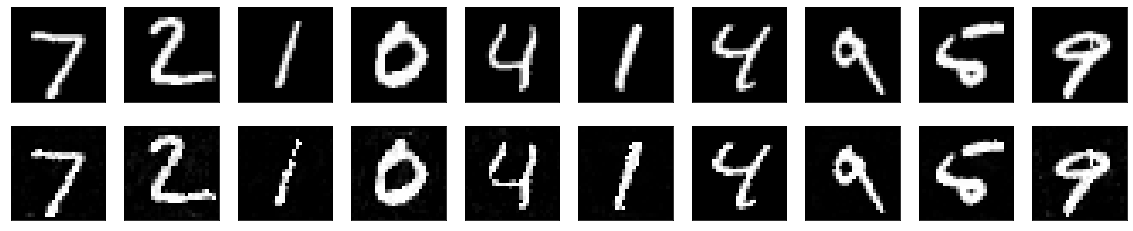

In [ ]:
#Show ten original samples and their corresponding adversarial samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display adversarial
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(CW_attack_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
#FILL THIS IN 

# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100, activation="relu", input_dim = 100))
    model.add(BatchNormalization())
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax"))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
pca_model = pca_model()

pca_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

pca_model_mdata = pca_model.fit(
  pca_train, 
  labels_train,
  validation_data=(pca_test, labels_test),
  epochs=50,
  batch_size=256,
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.4839 - accuracy: 0.8554 - val_loss: 0.2133 - val_accuracy: 0.9462
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1564 - accuracy: 0.9550 - val_loss: 0.1262 - val_accuracy: 0.9638
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1052 - accuracy: 0.9696 - val_loss: 0.1016 - val_accuracy: 0.9700
Epoch 4/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0768 - accuracy: 0.9779 - val_loss: 0.0933 - val_accuracy: 0.9720
Epoch 5/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0590 - accuracy: 0.9832 - val_loss: 0.0856 - val_accuracy: 0.9744
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0465 - accuracy: 0.9870 - val_loss: 0.0789 - val_accuracy: 0.9770
Epoch 7/50
60000/60000 [==============================] - 1s 24us/s

In [ ]:
#Using the defense (and comparing to baseline accuracy)
pca_CW_attack_data = pca.transform(CW_attack_data)
pca_model_scores = pca_model.evaluate(pca_CW_attack_data, labels_test)
print("Accuracy: %.2f%%" %(pca_model_scores[1]*100))

10000/10000 [==============================] - 1s 61us/step
Accuracy: 96.69%


#Part 5: DeepFool 

In [ ]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
DF = DeepFool(wrap, sess=sess)

#Attack parameters
DF_params = {'nb_candidate': 10,
             'max_iter': 50,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
DF_attack_data = DF.generate_np(data_test, **DF_params)

#Evaluate accuracy of perturbed data on target classifier
DF_adv_scores = Classifier.evaluate(DF_attack_data, labels_test)
print("DF Adversarial Attack Accuracy: %.2f%%" %(DF_adv_scores[1]*100))



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 1s 57us/step
DF Adversarial Attack Accuracy: 1.70%


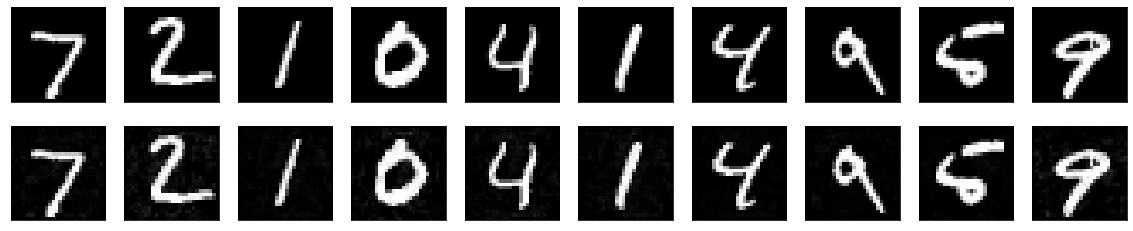

In [ ]:
#Show ten original samples and their corresponding adversarial samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display adversarial
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(DF_attack_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Implementing the Denoising Autoencoder Defense

def DAE():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
DF_attack_data_train = DF.generate_np(data_train, **DF_params)
#data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph
DAE = DAE()

DAE.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['accuracy'],
)

DAE_mdata = DAE.fit(
  DF_attack_data_train, 
  data_train,
  validation_data=(DF_attack_data, data_test),
  epochs=50,
  batch_size=256,
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0381 - accuracy: 0.0102 - val_loss: 0.0163 - val_accuracy: 0.0099
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0124 - accuracy: 0.0114 - val_loss: 0.0096 - val_accuracy: 0.0131
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0088 - accuracy: 0.0124 - val_loss: 0.0074 - val_accuracy: 0.0123
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0070 - accuracy: 0.0131 - val_loss: 0.0061 - val_accuracy: 0.0110
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0058 - accuracy: 0.0121 - val_loss: 0.0052 - val_accuracy: 0.0116
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0051 - accuracy: 0.0121 - val_loss: 0.0047 - val_accuracy: 0.0129
Epoch 7/50
60000/60000 [==============================] - 1s 21us/st

In [ ]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
Reomve_DF = DAE.predict(DF_attack_data)

#Evaluate accuracy of DF samples after denoising 
Reomve_DF_scores = Classifier.evaluate(Reomve_DF, labels_test)
print("Accuracy: %.2f%%" %(Reomve_DF_scores[1]*100))

10000/10000 [==============================] - 1s 58us/step
Accuracy: 97.46%


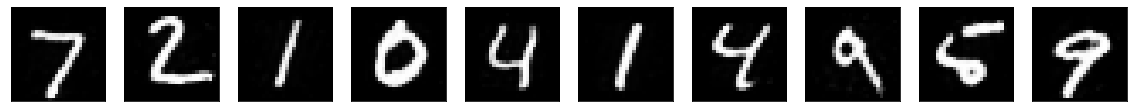

In [ ]:
#Show ten samples of adversarial samples after denoising
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Reomve_DF[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()